In [1]:
import json
import pickle
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

sys.path.append('..')
from utils.amt_inout import bounded_curve, bounded_sigmoid
from utils.stock_loader import Loader

In [2]:
SYM = 'GDX'  # gold
START = '1965-01-01'
PARAM_PATH = '../data/inout_params_gdx.pkl'
loader = Loader([SYM], START)
df = loader.download()
df.set_index('Date', drop=True, inplace=True)
df.columns = [
    'open', 'high', 'low', 'close', 'value', 'logval',
    'intraday_change', 'day_to_day_change', 'overnight_change']
df.logval.fillna(method='ffill')
for adj in ['overnight_change', 'day_to_day_change']:
    df[adj] = pd.Series(
        np.concatenate([df[adj].values[1:], [np.nan]]), index=df.index)
print(df.shape)
df.head(10)

[*********************100%%**********************]  1 of 1 completed


Generating derived columns...
(4165, 9)


,open,high,low,close,value,logval,intraday_change,day_to_day_change,overnight_change
Date,,,,,,,,,
2008-01-02,46.689999,49.270000,46.689999,49.240002,43.426861,3.771078,1.054616,1.030463,1.002234
2008-01-03,49.349998,51.180000,49.099998,50.740002,44.749775,3.801086,1.028166,0.983445,0.990934
2008-01-04,50.279999,50.349998,49.279999,49.900002,44.008953,3.784393,0.992442,0.983166,0.998196
2008-01-07,49.810001,50.279999,48.520000,49.060001,43.268112,3.767416,0.984943,1.035467,1.034244
2008-01-08,50.740002,51.980000,50.599998,50.799999,44.802685,3.802268,1.001182,1.006496,1.000197
2008-01-09,50.810001,51.189999,50.160000,51.130001,45.093739,3.808743,1.006298,1.017406,0.994719
2008-01-10,50.860001,52.459999,50.349998,52.020000,45.878658,3.826000,1.022808,1.007689,0.999616
2008-01-11,52.000000,53.200001,51.799999,52.419998,46.231441,3.833660,1.008077,1.017169,1.030713
2008-01-14,54.029999,54.230000,53.090000,53.320000,47.025192,3.850683,0.986859,0.960427,0.995311


In [3]:
df.isnull().sum()

open                 0
high                 0
low                  0
close                0
value                0
logval               0
intraday_change      0
day_to_day_change    1
overnight_change     1
dtype: int64

In [4]:
df.fillna(method='ffill', inplace=True)
df.isnull().sum()

open                 0
high                 0
low                  0
close                0
value                0
logval               0
intraday_change      0
day_to_day_change    0
overnight_change     0
dtype: int64

In [5]:
df.high[(df.high != df.low)]

Date
2008-01-02    49.270000
2008-01-03    51.180000
2008-01-04    50.349998
2008-01-07    50.279999
2008-01-08    51.980000
                ...    
2024-07-15    38.580002
2024-07-16    39.320000
2024-07-17    39.410000
2024-07-18    38.689999
2024-07-19    37.710098
Name: high, Length: 4165, dtype: float64

In [6]:
SIM_START = pd.to_datetime('2008-01-02')  # first day of legit open/close values
SIM_START

Timestamp('2008-01-02 00:00:00')

In [7]:
len(df.index >= SIM_START)

4165

In [8]:
def get_random_params():
    k = np.random.uniform(1, 10)
    if np.random.choice([True, False]):
        k = 1/k
    return {
        'time_param': np.random.randint(5, 250),
        'method':     np.random.choice(['ew', 'ma', 'linear_ma', 'linear']),
        't':          np.random.uniform(0, 1),
        'k':          k,
        'as_q':       np.random.choice([True, False]),
        'transform_f': np.random.choice(['bounded_curve', 'bounded_sigmoid'])}

In [9]:
def tweak_best_params(params, factor=2, numeric_only=False):
    '''A small factor should have values very close to current, larger
    values allow wilder fluctuations'''
    time = params['time_param']
    upper = time * factor
    diff = upper - time
    time = np.random.randint(time - diff, upper)
    time = min(max(5, time), 1000)
    
    method = params['method']
    if not numeric_only:
        meths = ['ew', 'ma', 'linear_ma', 'linear']
        idx = meths.index(method)
        ps = np.array([1, 1, 1, 1])
        ps[idx] = factor
        ps = ps / ps.sum()
        method = np.random.choice(meths, p=ps)
    
    t = params['t']
    sd = 1 - 1 / (factor/2 + 1)
    t = min(max(np.random.normal(t, scale=sd), 0.001), 0.999)
    
    k = params['k']
    upper = k * factor
    diff = upper - k
    k = np.random.uniform(k - diff, upper)
    k = min(max(1/10, k), 10)
    
    as_q = params['as_q'] if numeric_only else np.random.choice([True, False]) 
    
    current_transform = params['transform_f']
    other_transform = 'bounded_curve' if current_transform == 'bounded_sigmoid' else 'bounded_sigmoid'
    p_current = 1 / factor
    transform_f = np.random.choice([current_transform, other_transform], p=[p_current, 1 - p_current])
    return {
        'time_param': time,
        'method': method,
        't': t,
        'k': k,
        'as_q': as_q,
        'transform_f': transform_f}

In [10]:
def get_ma(series: pd.Series, time_param: float | int, method: str):
    '''Calculate the moving average
    Args:
    - method: 'ew' | 'ma' | 'linear' | 'linear_ma'
    - time_param:
      - ew=True: (real) the halflife of the exponential weights (no. 
          of  time periods it takes for weight to drop from 1 to 0.5)
      - ew=False: (int) the ma window, or number of days to average 
   over
    '''
    if method == 'ew':
        trend = series.ewm(halflife=time_param, ignore_na=True).mean()
    elif method == 'ma':
        trend = series.rolling(window=int(time_param)).mean()
    elif method.startswith('linear'):
        trend = (series).rolling(window=int(time_param)).apply(lambda x: (x[-1] + x[0]) / 2)
        if method == 'linear_ma':
            trend = trend.rolling(window=int(time_param)).mean()
        trend.fillna(method='bfill', inplace=True)
    return trend

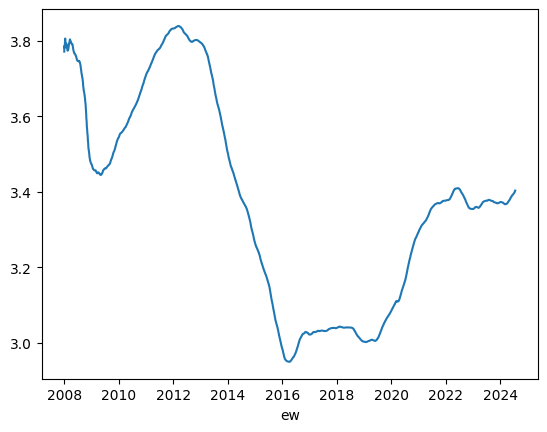

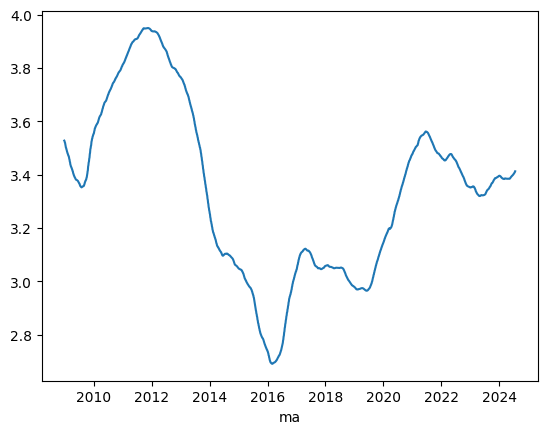

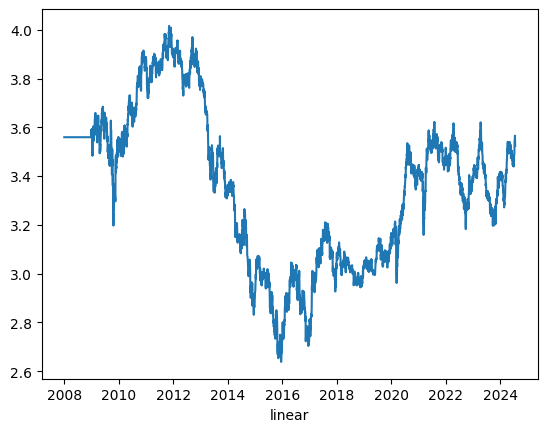

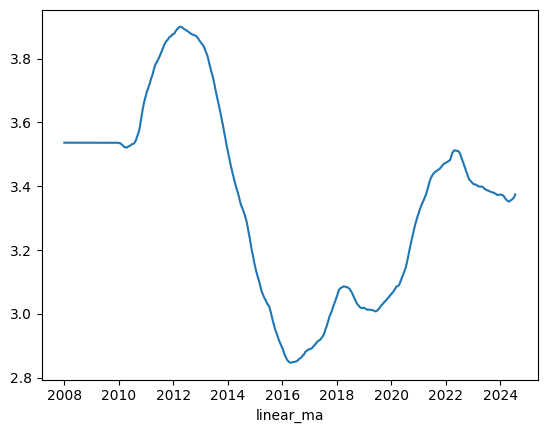

In [11]:
for method in ['ew', 'ma', 'linear', 'linear_ma']:
    plt.plot(get_ma(df.logval, 250, method))
    plt.xlabel(method)
    plt.show()

In [12]:
def get_trend_multiple(series, time_param, method, as_q):
    'Get deviates (as quantiles) relative to trend'
    trend = get_ma(series, time_param, method)
    factor = series / trend
    if as_q:
        factor = factor.rank() / len(factor)
    return factor

In [13]:
def rescale_minmax(series, mn=0, mx=1):
    s = series.copy()
    out_rng = mx - mn
    obs_min = s.min()
    s -= obs_min
    obs_max = s.max()
    s /= obs_max
    s *= out_rng
    s += mn
    return s

In [14]:
def calculate_next_row(row):
    invested = row.invested * row.overnight_change
    total = invested + row.reserve
    target_in = total * row.amt_in
    diff = target_in - invested  # if diff+ buy; - sell
    invested += diff
    reserve = row.reserve - diff
    invested *= row.day_to_day_change
    return invested, reserve, invested + reserve

In [15]:
def simulate(df, params):
    df['trend_factor'] = rescale_minmax(
        get_trend_multiple(
            df.logval,
            params['time_param'],
            method=params['method'],
            as_q=params['as_q']))
    if params['transform_f'] == 'bounded_curve':
        df['amt_in'] = bounded_curve(
            df.trend_factor, params['t'], params['k'], 'down')
    elif params['transform_f'] == 'bounded_sigmoid':
        df['amt_in'] = bounded_sigmoid(
            df.trend_factor, params['t'], params['k'], 'down')
    df = df.loc[df.index >= SIM_START, :].copy()
    df['invested'] = np.nan
    df['reserve'] = np.nan
    df['total'] = np.nan
    df['invested'][0] = df.amt_in[0]
    df['reserve'][0] = 1 - df.amt_in[0]
    df['total'][0] = 1
    for i in range(len(df) - 1) :
        row = df.iloc[i, :]
        try:
            nxt_idx = df.index[i + 1]
            df.loc[nxt_idx, ['invested', 'reserve', 'total']] = (
                calculate_next_row(row))
        except IndexError:
            break
    return df

In [16]:
def run_simulation(
        df, iters=100, current_best=None, best_params=None, 
        param_select='random', factor=2, numeric_only=False):
    orig_df = df.copy()
    do_nothing_res = orig_df.value[-1] / orig_df.loc[SIM_START, 'value']
    print('Do nothing res:', do_nothing_res)
    if current_best is None:
        current_best = 0
    for i in range(iters):
        print('Round', i + 1, end=': ')
        if i == 0 and best_params is not None and param_select == 'random':
            params = best_params  # rerun again on new data
            current_best = 0 
        elif param_select == 'random':
            params = get_random_params()
        else:
            params = (
                tweak_best_params(best_params, factor, numeric_only=numeric_only)
                if best_params is not None else get_random_params())
        df = simulate(orig_df.copy(), params)
        final = df.total[-1]
        print(final)
        if np.isnan(final):
            continue
            #return df, params
        if final > current_best:
            current_best = final
            best_params = params
            print('New best:', current_best)
            print(params)
            plt.plot(df.total, label='best')
            plt.plot(df.value / df.value[0], label='S&P')
            plt.yscale('log')
            plt.legend()
            plt.show()
    return current_best, best_params

In [17]:
try:
    with open(PARAM_PATH, 'rb') as f:
        current_best, best_params = pickle.load(f)
except FileNotFoundError:
    current_best, best_params = None, None
    
current_best, best_params

(123.88297102390379,
 {'time_param': 236,
  'method': 'ew',
  't': 0.8657287984016523,
  'k': 4.754218008784482,
  'as_q': True,
  'transform_f': 'bounded_sigmoid'})

Do nothing res: 0.8609878469875197
Round 1: 123.35491775542367
New best: 123.35491775542367
{'time_param': 236, 'method': 'ew', 't': 0.8657287984016523, 'k': 4.754218008784482, 'as_q': True, 'transform_f': 'bounded_sigmoid'}


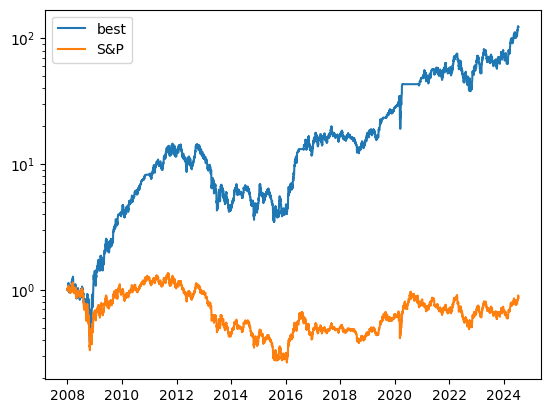

Round 2: nan
Round 3: 11.060260672548534
Round 4: 50.64774437401424
Round 5: nan
Round 6: 22.21810400417251
Round 7: 1.7394633789465554
Round 8: 32.133460230681784
Round 9: nan
Round 10: 47.96135714399612
Round 11: 14.58244606930116
Round 12: 46.61528875521262
Round 13: 7.042881961698696
Round 14: 54.127070032737535
Round 15: 4.1428370130686165
Round 16: 54.565527259152624
Round 17: 7.369278728780945
Round 18: 46.773361170686115
Round 19: 50.982326832634904
Round 20: nan
Round 21: 61.55486161408225
Round 22: nan
Round 23: 12.359833894792615
Round 24: 41.97176455175478
Round 25: 16.00986283927807
Round 26: 4.472424805148195
Round 27: nan
Round 28: 54.844057732761286
Round 29: 11.638770700069745
Round 30: 42.06931042977421
Round 31: nan
Round 32: nan
Round 33: 6.406724557038201
Round 34: nan
Round 35: nan
Round 36: nan
Round 37: 80.57692623212733
Round 38: 15.301592998016392
Round 39: 47.08347724417817
Round 40: 24.668835309184125
Round 41: 30.984100432274786
Round 42: nan
Round 43: nan


In [18]:
best_out, params_out = run_simulation(
    df.copy(), current_best=current_best, best_params=best_params)

In [19]:
# initially [1/4, 1/2, 1, 2]
for w in [16, 32, 64, 128]:  # bigger w -> smaller factor -> smaller changes
    factor = 1 + (1/w)
    print('Factor:', factor)
    best_out, params_out = run_simulation(
        df.copy(), 
        iters=25, 
        current_best=best_out, 
        best_params=params_out, 
        param_select='tweak',
        factor=factor,  # closer to 1: small changes; bigger: bigger
        numeric_only=True) 
    print()

Factor: 1.0625
Do nothing res: 0.8609878469875197
Round 1: 48.64876030614946
Round 2: 52.59032106959369
Round 3: 110.58458524840557
Round 4: 83.99295698026461
Round 5: 48.6328841090857
Round 6: 48.6454625582378
Round 7: 48.63872851523242
Round 8: 16.192249227947535
Round 9: 68.0252650021619
Round 10: 48.64098046190547
Round 11: 80.97172168340208
Round 12: 48.63308319353253
Round 13: 28.262543509151413
Round 14: 52.25466463708821
Round 15: 36.40117694239436
Round 16: 85.54959528406698
Round 17: 13.250454545061507
Round 18: 48.64475761719179
Round 19: 48.62152465357577
Round 20: 31.014743226364093
Round 21: 101.94027141307726
Round 22: 30.770654850658126
Round 23: 7.498101763429972
Round 24: 113.55024139145576
Round 25: 35.69283697452258

Factor: 1.03125
Do nothing res: 0.8609878469875197
Round 1: 55.85334087764475
Round 2: 44.532049000712334
Round 3: 120.46444553635841
Round 4: 34.068512710366925
Round 5: 42.68900368068811
Round 6: 48.62919844049828
Round 7: 48.630394437566636
Round 8: 

In [20]:
# Force set:
#best_out = 8.746647001172413
#params_out = {'time_param': 39, 'method': 'ma', 't': 0.9119734669470952, 'k': 6.934678320149607, 'as_q': True, 'transform_f': 'bounded_curve'}

In [21]:
final_out = simulate(df, params_out)

In [22]:
amt_in = final_out['amt_in'][-1]
amt_in

0.5091613998954122

In [23]:
trend_fac = final_out['trend_factor'][-1]
trend_fac

0.8650336215177713

In [24]:
params_out

{'time_param': 236,
 'method': 'ew',
 't': 0.8657287984016523,
 'k': 4.754218008784482,
 'as_q': True,
 'transform_f': 'bounded_sigmoid'}

/Users/damiansp/Learning/marketModeling/notebooks/../utils/amt_inout.py:48: RuntimeWarning: divide by zero encountered in power
  y = 1 / (1 + (x**(np.log(2) / np.log(t)) - 1) ** k)


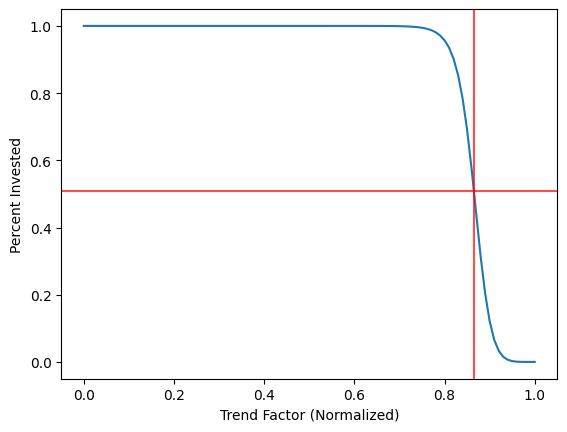

In [25]:
xs = np.linspace(0, 1, 101)
if params_out['transform_f'] == 'bounded_curve':
    ys = bounded_curve(xs, params_out['t'], params_out['k'], 'down')
else:
    ys = bounded_sigmoid(xs, params_out['t'], params_out['k'], 'down')
plt.xlabel('Trend Factor (Normalized)')
plt.ylabel('Percent Invested')
plt.plot(xs, ys)
plt.axhline(amt_in, color='r', alpha=0.7)
plt.axvline(trend_fac, color='r', alpha=0.7);

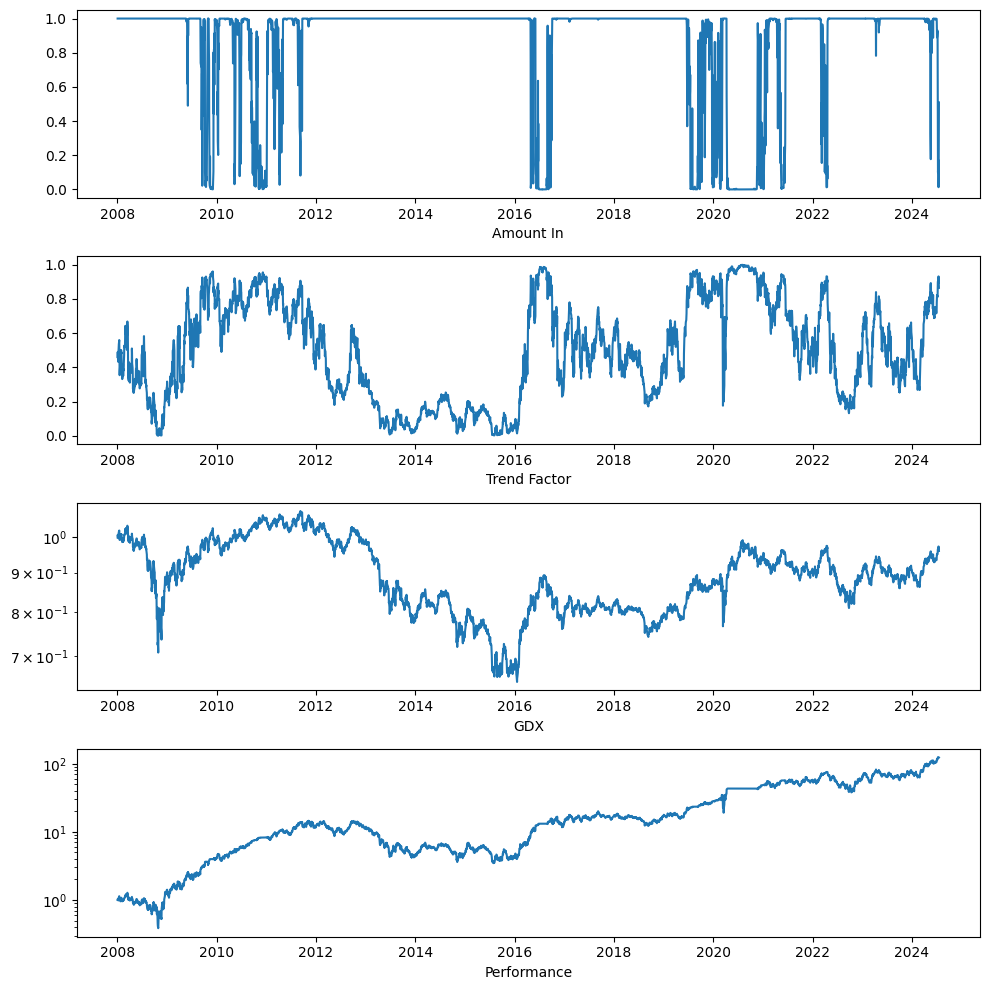

In [26]:
plt.figure(figsize=(10, 10))
plt.subplot(4, 1, 1)
plt.plot(final_out.amt_in)
plt.xlabel('Amount In')

plt.subplot(4, 1, 2)
plt.plot(final_out.trend_factor)
plt.xlabel('Trend Factor')

plt.subplot(4, 1, 3)
plt.plot(final_out.logval / final_out.logval[0])
plt.xlabel('GDX')
plt.yscale('log')

plt.subplot(4, 1, 4)
plt.plot(final_out.total)
plt.xlabel('Performance')
plt.yscale('log')
plt.tight_layout();

In [27]:
N = 500
#plt.figure(figsize=(10, 10))
#plt.subplot(4, 1, 1)
#plt.plot(final_out.amt_in[:N])
#plt.xlabel('Amount In')

#plt.subplot(4, 1, 2)
#plt.plot(final_out.trend_factor[:N])
#plt.xlabel('Trend Factor')

#plt.subplot(4, 1, 3)
#plt.plot((final_out.logval / final_out.logval[0])[:N])
#plt.xlabel('Wilshire')
#plt.yscale('log')

#plt.subplot(4, 1, 4)
#plt.plot(final_out.total[:N])
#plt.xlabel('Performance')
#plt.yscale('log')
#plt.tight_layout();

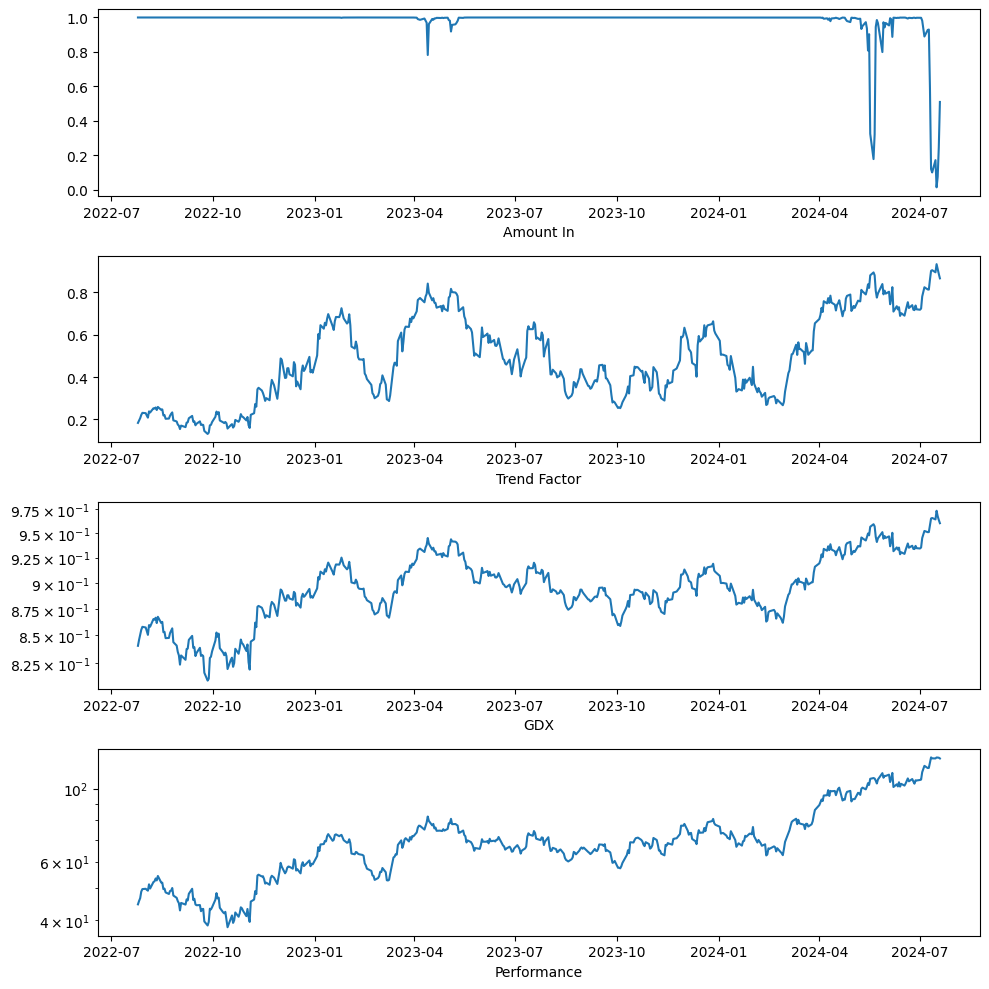

In [28]:
plt.figure(figsize=(10, 10))
plt.subplot(4, 1, 1)
plt.plot(final_out.amt_in[-N:])
plt.xlabel('Amount In')

plt.subplot(4, 1, 2)
plt.plot(final_out.trend_factor[-N:])
plt.xlabel('Trend Factor')

plt.subplot(4, 1, 3)
plt.plot((final_out.logval / final_out.logval[0])[-N:])
plt.xlabel('GDX')
plt.yscale('log')

plt.subplot(4, 1, 4)
plt.plot(final_out.total[-N:])
plt.xlabel('Performance')
plt.yscale('log')
plt.tight_layout();

In [29]:
frac_in = round(final_out['amt_in'][-1], 4)
frac_in

0.5092

In [30]:
# n days
n = (df.index >= SIM_START).sum()
# n years
t = n / 250
# amt at start
p = df.loc[SIM_START, 'value']
amt = df.iloc[-1].value
p, t, amt

(43.42686080932617, 16.66, 37.38999938964844)

In [31]:
# annualized rate of return
r = best_out**(1/t) 
r - 1

0.33511783042683496

In [32]:
with open('daily_params.json', 'r') as f_in:
    j = json.load(f_in)
    with open('daily_params.json', 'w') as f_out:
        j['gdx'] = [r, frac_in]
        print(j)
        json.dump(j, f_out)

{'sp': [1.1174873659325364, 0.9999], 'nas': [1.2275959942624421, 0.9982], 'rus': [1.2680366015016034, 1.0], 'jpxn': [1.0672252720640971, 0.0], 'ktec': [1.6599402811386, 0.0], 'emb': [1.0683946681306238, 1.0], 'gdx': [1.335117830426835, 0.5092], 'dia': [1.2015064238720055, 1.0]}


In [33]:
stop

NameError: name 'stop' is not defined

In [34]:
with open(PARAM_PATH, 'wb') as f:
    pickle.dump([best_out, params_out], f)
    
best_out, params_out

(123.35491775542367,
 {'time_param': 236,
  'method': 'ew',
  't': 0.8657287984016523,
  'k': 4.754218008784482,
  'as_q': True,
  'transform_f': 'bounded_sigmoid'})

In [37]:
keys = ['sp', 'nas', 'dia', 'rus', 'jpxn', 'ktec', 'emb', 'gdx']
rs = np.array([j[k][0] - 1 for k in keys])

# Manually reduce KTEC & GDX
idx_ktec = keys.index('ktec')
rs[idx_ktec] /= 10
idx_gdx = keys.index('gdx')
rs[idx_gdx] /= 5
#

rs = rs / rs.sum()
for k, r in zip(keys, rs):
    print(f'{k:4s}: {r:.4f}')

sp  : 0.1085
nas : 0.2101
dia : 0.1860
rus : 0.2474
jpxn: 0.0621
ktec: 0.0609
emb : 0.0631
gdx : 0.0619


In [38]:
fracs_in = np.array([j[k][1]  for k in keys])
for k, f in zip(keys, fracs_in):
    print(f'{k:4s}: {f:.4f}')

sp  : 0.9999
nas : 0.9982
dia : 1.0000
rus : 1.0000
jpxn: 0.0000
ktec: 0.0000
emb : 1.0000
gdx : 0.5092


In [39]:
cash = 15414       # Don't Forget Me!!!
#                   SPY,   FNCMX, DIA,   IWF,   JPXN, KTEC, EMB,   GDX
current = np.array([20858, 41017, 36264, 62211, 0,    0,    12496, 1944])


val = current.sum() + cash
target = (val * rs * fracs_in).round()
for k, t in zip(keys, target):
    print(f'{k:4s}: {t:7.0f}')

sp  :   21077
nas :   40761
dia :   36153
rus :   48090
jpxn:       0
ktec:       0
emb :   12271
gdx :    6123


In [40]:
for k, diff in zip(keys, target - current):
    print(f'{k:4s}: {diff:7.0f}')

sp  :     219
nas :    -256
dia :    -111
rus :  -14121
jpxn:       0
ktec:       0
emb :    -225
gdx :    4179


In [ ]:
start = 'emb'